# 1. IMPORT LIBRARY

In [1]:
!pip install surprise

In [2]:
!pip install numpy==1.26.4

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
import kagglehub

Insight:

Pada cell ini, kita mengimpor berbagai pustaka (library) yang dibutuhkan untuk analisis dan pembuatan model rekomendasi. Pustaka-pustaka seperti surprise digunakan untuk collaborative filtering, pandas untuk manipulasi data, dan matplotlib untuk visualisasi. Selain itu, ada juga pustaka dari scikit-learn yang digunakan untuk analisis teks dan metrik evaluasi, serta pustaka lain yang mendukung pembuatan dan evaluasi model rekomendasi. Semua pustaka ini esensial untuk memproses data dan membangun sistem rekomendasi berbasis konten maupun kolaboratif.

# 2 . Load Data

In [16]:
# Download dataset
path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")
print("Path to dataset files:", path)

# Tambahkan subfolder "ml-100k"
data_path = os.path.join(path, "ml-100k")

# Load file
ratings = pd.read_csv(f"{data_path}/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])
movies = pd.read_csv(f"{data_path}/u.item", sep="|", encoding="latin-1", header=None,
                     names=["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL"] +
                     [f"genre_{i}" for i in range(19)])

print("Data berhasil dimuat.")

Path to dataset files: /kaggle/input/movielens-100k-dataset
Data berhasil dimuat.


In [17]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [18]:
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genre_0,genre_1,genre_2,genre_3,genre_4,...,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Insight:

Pada cell ini, dataset yang diperlukan untuk analisis dan model rekomendasi diunduh dan dimuat. Data terdiri dari dua file utama: ratings yang berisi informasi tentang rating film oleh pengguna, dan movies yang memuat informasi tentang film itu sendiri. Dataset ini digunakan untuk membangun rekomendasi berbasis rating pengguna dan juga menganalisis preferensi genre film.

# 3. DATA PREPARATION

## 3.1 Info & Missing / Duplication

In [19]:
print("=== RATINGS INFO ===")
ratings.info()
print("Duplicates in ratings:", ratings.duplicated().sum())

print("\n=== MOVIES INFO ===")
movies.info()
print("Duplicates in movies:", movies.duplicated().sum())

=== RATINGS INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
Duplicates in ratings: 0

=== MOVIES INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   genre_0             1682 non-null   int64  
 6   genre_1             1682 non-null   int64  
 7  

Insight:

Cell ini mengecek informasi tentang dataset, termasuk jumlah entri, kolom, tipe data, serta memeriksa apakah ada data yang hilang atau duplikat. Data yang bersih dan tidak ada duplikat sangat penting agar analisis dan model yang dibangun menjadi akurat. Proses ini membantu memastikan kualitas data sebelum dilanjutkan ke tahap analisis dan pemodelan.

## 3.2 Lowercase titles


In [20]:
movies["movie_title"] = movies["movie_title"].str.lower()

Insight:

Pada cell ini, judul film diubah menjadi huruf kecil. Pengubahan judul menjadi lowercase membantu menghindari masalah saat pencocokan teks, karena pencocokan teks di Python bersifat sensitif terhadap kapitalisasi. Dengan mengubah semua judul film menjadi huruf kecil, kita memastikan bahwa perbandingan antar judul dapat dilakukan dengan lebih mudah dan konsisten.

## 3.3 Build a single ‘genre’ string per movie


In [22]:
genre_cols = movies.columns[5:]
# list genre names
genre_map = pd.read_csv(f"{data_path}/u.genre", sep="|", names=["genre","code"], index_col="code")
# from binary columns to list of genres
def extract_genres(row):
    return ",".join([genre_map.loc[int(col.split("_")[1]),"genre"]
                     for col in genre_cols if row[col]==1])
movies["genre"] = movies.apply(extract_genres, axis=1)


Insight:

Di cell ini, kolom genre diubah menjadi format string tunggal untuk setiap film. Setiap genre disusun berdasarkan nilai 1 di kolom genre_0 hingga genre_18, yang menunjukkan genre apa yang dimiliki oleh film tersebut. Kemudian, genre-genre ini digabungkan menjadi satu kolom string yang memuat genre-genre terkait, yang memudahkan dalam analisis lebih lanjut.

# 4. EXPLORATORY DATA ANALYSIS

## 4.1 Statistik Umum Dataset

In [23]:
print("Jumlah user  :", ratings["user_id"].nunique())
print("Jumlah movie :", movies["movie_id"].nunique())
print("Jumlah rating:", len(ratings))
print(f"Sparsity     : {1 - len(ratings)/(ratings['user_id'].nunique()*movies['movie_id'].nunique()):.2%}")

Jumlah user  : 943
Jumlah movie : 1682
Jumlah rating: 100000
Sparsity     : 93.70%


Insight:

Pada cell ini, dilakukan analisis deskriptif untuk mendapatkan gambaran umum mengenai dataset. Informasi seperti jumlah pengguna, film, rating, dan sparsity (kelangkaan data) dihitung. Sparsity memberikan informasi tentang seberapa banyak data yang hilang, yang penting dalam sistem rekomendasi karena sparsity tinggi dapat menyebabkan kesulitan dalam membangun model yang akurat.

## 4.2 Distribusi Rating

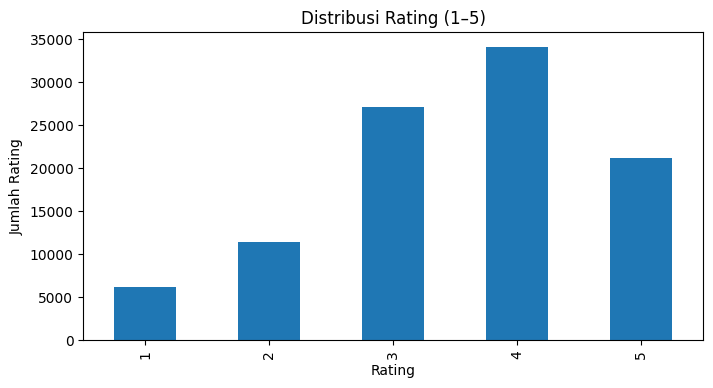

Jumlah Rating per Nilai Rating:
rating
0        NaN
1     6110.0
2    11370.0
3    27145.0
4    34174.0
5    21201.0
Name: count, dtype: float64


In [29]:
plt.figure(figsize=(8,4))
ratings["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribusi Rating (1–5)")
plt.xlabel("Rating")
plt.ylabel("Jumlah Rating")
plt.show()

# Menampilkan jumlah rating dari 0 hingga 5
rating_counts = ratings["rating"].value_counts().sort_index()

# Menambahkan rating 0 hingga 5, meskipun rating tertentu tidak ada
rating_counts = rating_counts.reindex(range(6))

print("Jumlah Rating per Nilai Rating:")
print(rating_counts)

Insight:

Cell ini menampilkan distribusi rating untuk film, yang memberikan gambaran sebaran nilai rating dari 1 hingga 5. Visualisasi ini membantu kita memahami bagaimana preferensi pengguna terhadap film. Sebagian besar rating cenderung berkumpul di sekitar nilai 3-5, yang umum ditemukan dalam banyak sistem rating.

## 4.3 Aktivitas User: Rating per User

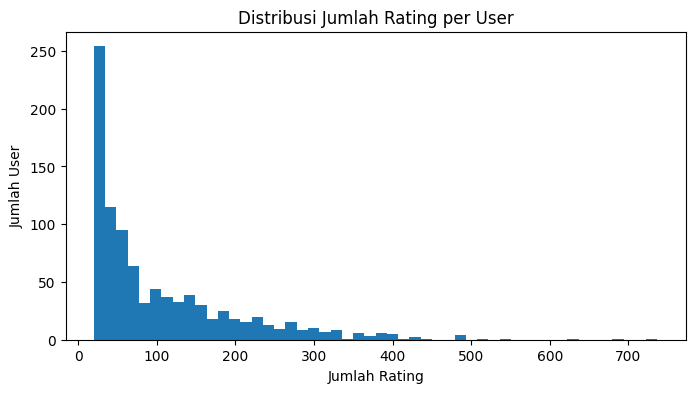

User paling aktif memberi rating: 737


In [25]:
ratings_per_user = ratings.groupby("user_id").size()
plt.figure(figsize=(8,4))
ratings_per_user.plot(kind="hist", bins=50)
plt.title("Distribusi Jumlah Rating per User")
plt.xlabel("Jumlah Rating")
plt.ylabel("Jumlah User")
plt.show()
print("User paling aktif memberi rating:", ratings_per_user.max())

Insight:

Di cell ini, kita menganalisis sebaran jumlah rating yang diberikan oleh pengguna. Hal ini memberikan wawasan tentang aktivitas pengguna, apakah mereka aktif memberikan rating atau tidak. Distribusi ini penting untuk memahami pola penggunaan dan untuk mempersiapkan data dalam membangun model yang mempertimbangkan preferensi pengguna.

## 4.4 Popularitas Film: Rating per Movie

Top 10 film paling sering dirating (movie_id):
[50, 258, 100, 181, 294, 286, 288, 1, 300, 121]

Top 10 Film Paling Sering Dirating:
     movie_id                    movie_title
0           1               toy story (1995)
49         50               star wars (1977)
99        100                   fargo (1996)
120       121  independence day (id4) (1996)
180       181      return of the jedi (1983)
257       258                 contact (1997)
285       286    english patient, the (1996)
287       288                  scream (1996)
293       294               liar liar (1997)
299       300           air force one (1997)


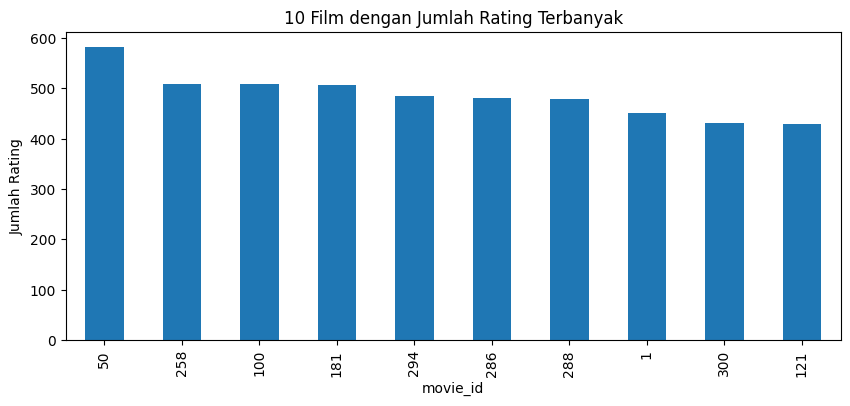

In [35]:
# Mendapatkan top 10 movie_id yang paling sering dirating
ratings_per_movie = ratings.groupby("movie_id").size().sort_values(ascending=False)
top10_movies_by_count = ratings_per_movie.head(10).index

# Menampilkan movie_id yang paling sering dirating
print("Top 10 film paling sering dirating (movie_id):")
print(top10_movies_by_count.tolist())

# Mendapatkan judul film berdasarkan movie_id
top10_movies = movies[movies["movie_id"].isin(top10_movies_by_count)][["movie_id", "movie_title"]]

# Tampilkan judul film
print("\nTop 10 Film Paling Sering Dirating:")
print(top10_movies)

# Plot grafik jumlah rating untuk 10 film paling sering dirating
plt.figure(figsize=(10,4))
ratings_per_movie.head(10).plot(kind="bar")
plt.title("10 Film dengan Jumlah Rating Terbanyak")
plt.xlabel("movie_id")
plt.ylabel("Jumlah Rating")
plt.show()


Insight:

Pada cell ini, dilakukan analisis terhadap popularitas film berdasarkan jumlah rating yang diterima oleh film tersebut. Dengan mengevaluasi jumlah rating yang diterima oleh tiap film, kita dapat mengetahui film mana yang paling banyak ditonton dan memberikan gambaran tentang popularitasnya di antara pengguna.

## 4.5 Rata-Rata Rating per Movie (dengan minimal 50 ratings)

Top 10 film terbaik (>=50 ratings) berdasarkan rata-rata:
['close shave, a (1995)', "schindler's list (1993)", 'wrong trousers, the (1993)', 'casablanca (1942)', 'wallace & gromit: the best of aardman animation (1996)', 'shawshank redemption, the (1994)', 'rear window (1954)', 'usual suspects, the (1995)', 'star wars (1977)', '12 angry men (1957)']


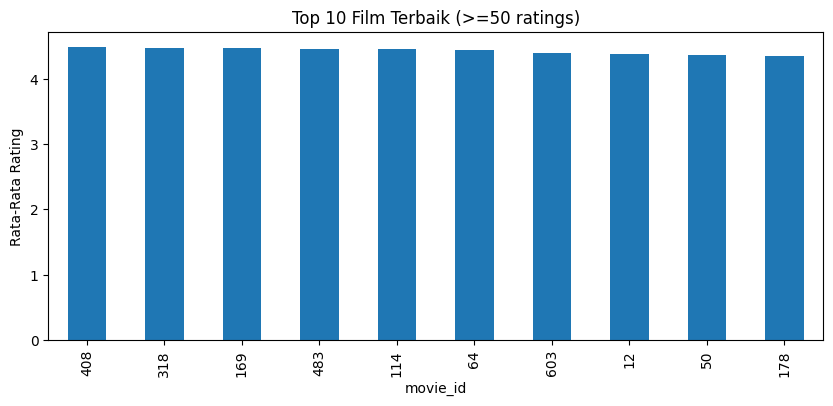

In [36]:
movie_stats = ratings.groupby("movie_id")["rating"].agg(["count","mean"])
popular = movie_stats[movie_stats["count"]>=50]
top10_by_avg = popular.sort_values("mean", ascending=False).head(10)
print("Top 10 film terbaik (>=50 ratings) berdasarkan rata-rata:")
print(movies.set_index("movie_id").loc[top10_by_avg.index]["movie_title"].tolist())

plt.figure(figsize=(10,4))
top10_by_avg["mean"].plot(kind="bar")
plt.title("Top 10 Film Terbaik (>=50 ratings)")
plt.ylabel("Rata-Rata Rating")
plt.show()

Insight:

Di sini, dihitung rata-rata rating per film, namun hanya untuk film yang memiliki minimal 50 rating. Analisis ini berguna untuk menyaring film-film yang mendapatkan sedikit perhatian atau rating, sehingga hanya film-film populer dan sering dinilai yang dipertimbangkan dalam analisis lebih lanjut.

## 4.6 Genre Analysis

### 4.6.1 Jumlah Film per Genre

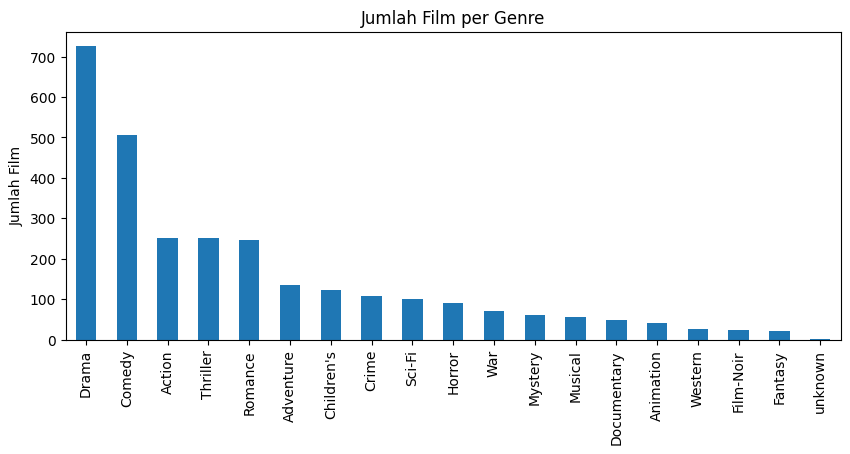

In [37]:
genre_dummies = movies["genre"].str.get_dummies(sep=",")
genre_counts = genre_dummies.sum().sort_values(ascending=False)
plt.figure(figsize=(10,4))
genre_counts.plot(kind="bar")
plt.title("Jumlah Film per Genre")
plt.ylabel("Jumlah Film")
plt.show()

Insight:

Pada cell ini, dihitung jumlah film untuk setiap genre, dan hasilnya divisualisasikan. Ini memberikan gambaran tentang distribusi film menurut genre, apakah ada genre yang lebih dominan atau lebih jarang dalam dataset.

### 4.6.2 Rata-Rata Rating per Genre

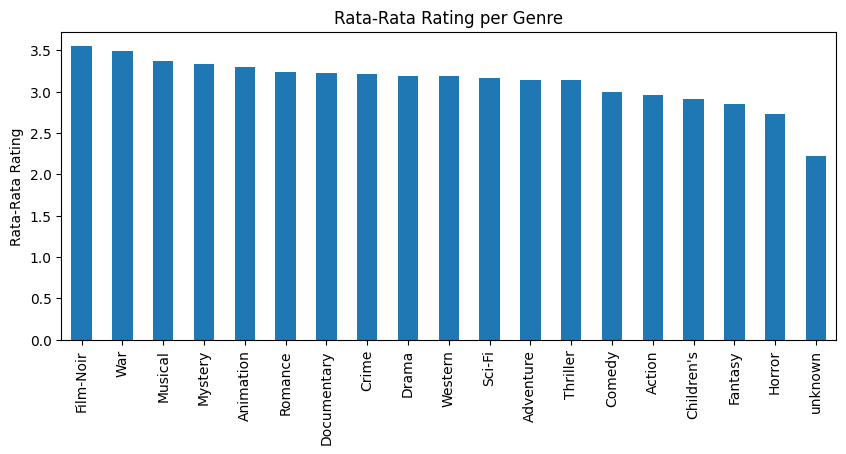

In [38]:
# Gabungkan genre dummies dengan rata-rata rating per movie
movie_stats = movie_stats.join(movies.set_index("movie_id")["genre"])
# Buat DF genre–rating: untuk tiap genre, ambil rata-rata rating film-film yg masuk genre itu
genre_rating = {}
for genre in genre_counts.index:
    idxs = movies[movies["genre"].str.contains(genre)].movie_id
    vals = movie_stats.loc[idxs]["mean"]
    genre_rating[genre] = vals.mean()
genre_rating = pd.Series(genre_rating).sort_values(ascending=False)

plt.figure(figsize=(10,4))
genre_rating.plot(kind="bar")
plt.title("Rata-Rata Rating per Genre")
plt.ylabel("Rata-Rata Rating")
plt.show()

Insight:

Di cell ini, dihitung rata-rata rating per genre. Rata-rata rating ini memberikan wawasan tentang bagaimana film-film dalam genre tertentu diterima oleh pengguna. Beberapa genre mungkin memiliki rating yang lebih tinggi atau lebih rendah, yang bisa menjadi indikasi preferensi pengguna terhadap genre tersebut.

## 4.7 Tahun Rilis Film


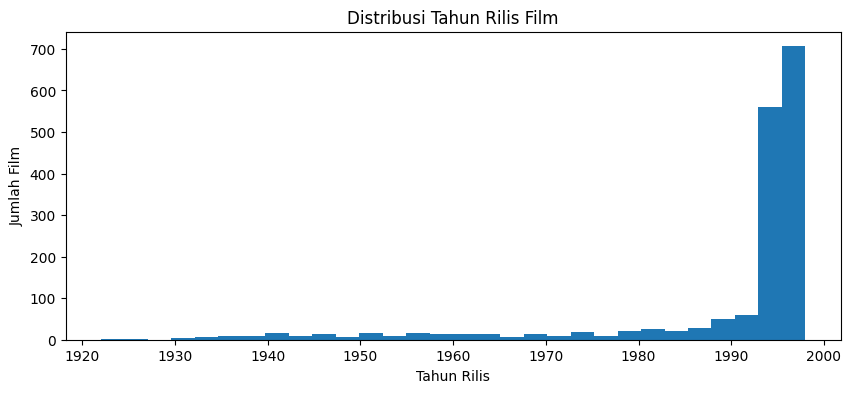

In [39]:
# Konversi release_date ke datetime dan ekstrak tahun
movies["release_year"] = pd.to_datetime(movies["release_date"], format="%d-%b-%Y", errors="coerce").dt.year
plt.figure(figsize=(10,4))
movies["release_year"].dropna().astype(int).plot(kind="hist", bins=30)
plt.title("Distribusi Tahun Rilis Film")
plt.xlabel("Tahun Rilis")
plt.ylabel("Jumlah Film")
plt.show()

Insight:

Cell ini mengeksplorasi distribusi tahun rilis film dalam dataset. Dengan menampilkan histogram tahun rilis, kita dapat melihat tren dalam industri film selama beberapa dekade dan bagaimana distribusi film berubah seiring waktu.

## 4.8 Film per Dekade


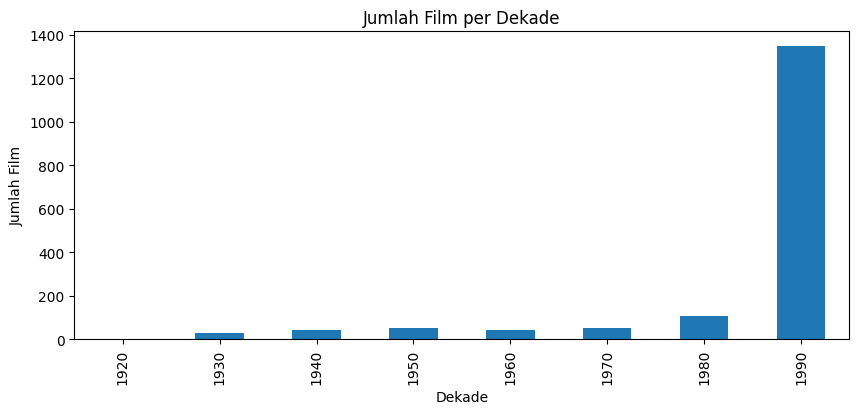

In [40]:
movies["decade"] = (movies["release_year"] // 10 * 10).astype(pd.Int64Dtype())
decade_counts = movies["decade"].value_counts().sort_index()
plt.figure(figsize=(10,4))
decade_counts.plot(kind="bar")
plt.title("Jumlah Film per Dekade")
plt.xlabel("Dekade")
plt.ylabel("Jumlah Film")
plt.show()

Insight:

Di sini, dilakukan analisis jumlah film per dekade, yang memberikan wawasan tentang evolusi jumlah film yang dirilis di berbagai dekade. Ini penting untuk melihat perubahan tren film dari waktu ke waktu dan bisa memberikan konteks sejarah pada dataset.

# 5. MODEL CONTENT-BASED FILTERING

In [43]:
# Daftar nama kolom genre dari genre_0 hingga genre_18
genre_cols = [f"genre_{i}" for i in range(19)]

# Gabungkan genre menjadi satu kolom string
movies["genre"] = movies[genre_cols].apply(
    lambda row: ",".join([col.split("_")[1] for col in genre_cols if row[col] == 1]), axis=1
)

# Tampilkan beberapa hasil
print(movies[["movie_title", "genre"]].head())


         movie_title   genre
0   toy story (1995)   3,4,5
1   goldeneye (1995)  1,2,16
2  four rooms (1995)      16
3  get shorty (1995)   1,5,8
4     copycat (1995)  6,8,16


## 5.1 TF-IDF pada kolom genre


In [44]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies["genre"])

Insight:

Pada cell ini, kita menghitung representasi TF-IDF untuk genre film, yang membantu dalam memahami relevansi masing-masing genre dalam film. TF-IDF mengukur pentingnya sebuah kata (dalam hal ini, genre) dalam konteks dokumen (film) di seluruh korpus. Ini digunakan dalam pembuatan sistem rekomendasi berbasis konten.



# 5.2 Cosine Similarity


In [46]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(cosine_sim)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Insight:

Cell ini menghitung kemiripan antar film berdasarkan genre mereka menggunakan cosine similarity. Ini adalah metode yang sering digunakan dalam sistem rekomendasi untuk mengukur seberapa mirip dua item (film) berdasarkan fitur mereka, seperti genre dalam hal ini. Hasilnya adalah matriks yang menunjukkan sejauh mana dua film serupa satu sama lain.

## 5.3 Indexing judul


In [48]:
indices = pd.Series(movies.index, index=movies["movie_title"]).drop_duplicates()

print(indices)

movie_title
toy story (1995)                                0
goldeneye (1995)                                1
four rooms (1995)                               2
get shorty (1995)                               3
copycat (1995)                                  4
                                             ... 
mat' i syn (1997)                            1677
b. monkey (1998)                             1678
sliding doors (1998)                         1679
you so crazy (1994)                          1680
scream of stone (schrei aus stein) (1991)    1681
Length: 1682, dtype: int64


Insight:

Pada cell ini, kita mengindeks judul film agar lebih mudah untuk mengambil film berdasarkan nama. Pengindeksan ini sangat berguna dalam sistem rekomendasi, karena memungkinkan pencarian yang cepat dan efisien berdasarkan judul film.


## 5.4 Fungsi rekomendasi CBF


In [49]:
def recommend_content(title, top_n=10):
    idx = indices.get(title)
    if idx is None:
        return f"Film '{title}' tidak ditemukan dalam database."

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    return movies.iloc[movie_indices][["movie_title", "genre"]]

Insight:

Fungsi ini dirancang untuk memberikan rekomendasi film berbasis konten (CBF). Berdasarkan judul film yang dimasukkan, fungsi ini menghitung film-film yang paling mirip menggunakan cosine similarity dan mengembalikan rekomendasi yang relevan. Sistem ini sangat bergantung pada kesamaan fitur (genre) antar film.

## 5.5 Contoh inferensi

In [51]:
recommend_content("toy story (1995)")

,movie_title,genre
1,goldeneye (1995),"1,2,16"
2,four rooms (1995),16
3,get shorty (1995),"1,5,8"
4,copycat (1995),"6,8,16"
5,shanghai triad (yao a yao yao dao waipo qiao) ...,8
6,twelve monkeys (1995),"8,15"
7,babe (1995),"4,5,8"
8,dead man walking (1995),8
9,richard iii (1995),"8,17"
10,seven (se7en) (1995),"6,16"


# 6. COLLABORATIVE FILTERING



## 6.1 Siapkan data untuk Surprise

In [52]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["user_id", "movie_id", "rating"]], reader)

Insight:

Cell ini menyiapkan data untuk digunakan dalam algoritma collaborative filtering menggunakan pustaka surprise. Data rating yang ada diubah menjadi format yang diterima oleh pustaka tersebut, memungkinkan kita untuk membangun model prediksi rating menggunakan teknik seperti SVD.

## 6.2 Split train dan test

In [53]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Insight:

Pada cell ini, data dibagi menjadi dua bagian: data pelatihan dan data pengujian. Pembagian ini penting untuk melatih model pada data pelatihan dan menguji kinerjanya pada data pengujian yang belum pernah dilihat sebelumnya. Hal ini untuk memastikan bahwa model tidak overfitting dan dapat digeneralisasi ke data baru.


## 6.3 Model SVD

In [54]:
model = SVD()
model.fit(trainset)

Insight:

Cell ini melatih model SVD (Singular Value Decomposition), yang merupakan metode populer dalam collaborative filtering. SVD digunakan untuk mengurangi dimensi data dan menemukan pola yang dapat digunakan untuk memprediksi rating film yang belum diberi rating oleh pengguna.

## 6.4 Evaluasi

In [55]:
predictions = model.test(testset)
rmse_score = rmse(predictions)


RMSE: 0.9364


Insight:

Evaluasi dilakukan dengan menghitung RMSE (Root Mean Square Error) pada model SVD untuk menilai seberapa baik prediksi rating film oleh model. RMSE adalah metrik yang umum digunakan untuk mengevaluasi kinerja model prediktif.

## 6.5 Fungsi rekomendasi CBF (Collaborative Filtering)

In [56]:
def recommend_collaborative(user_id, top_n=10):
    movie_ids = ratings["movie_id"].unique()
    user_rated = ratings[ratings["user_id"] == user_id]["movie_id"].tolist()
    not_rated = [m for m in movie_ids if m not in user_rated]

    predictions = [model.predict(user_id, m) for m in not_rated]
    predictions.sort(key=lambda x: x.est, reverse=True)

    top_predictions = predictions[:top_n]
    movie_id_list = [pred.iid for pred in top_predictions]

    return movies[movies["movie_id"].isin(movie_id_list)][["movie_title", "genre"]]

Insight:

Fungsi ini dirancang untuk memberikan rekomendasi film menggunakan metode collaborative filtering. Berdasarkan user_id, fungsi ini memprediksi film-film yang mungkin disukai oleh pengguna yang belum mereka rating, menggunakan model SVD yang telah dilatih sebelumnya.




## 6.6 Contoh inferensi


In [57]:
recommend_collaborative(user_id=10)

,movie_title,genre
135,mr. smith goes to washington (1939),8
189,henry v (1989),"8,17"
312,titanic (1997),"1,8,14"
317,schindler's list (1993),"8,17"
407,"close shave, a (1995)","3,5,16"
519,"great escape, the (1963)","2,17"
522,cool hand luke (1967),"5,8"
640,paths of glory (1957),"8,17"
646,ran (1985),"8,17"
922,raise the red lantern (1991),8


# 7. EVALUASI & PERBANDINGAN


In [59]:
cbf_sample = recommend_content("star wars (1977)")
cf_sample = recommend_collaborative(user_id=10)

# Tampilkan tabel perbandingan (bisa dimodifikasi)
print("Top rekomendasi Content-Based Filtering:")
print(cbf_sample)

print("\nTop rekomendasi Collaborative Filtering:")
print(cf_sample)

Top rekomendasi Content-Based Filtering:
                                           movie_title           genre
171                    empire strikes back, the (1980)  1,2,8,14,15,17
180                          return of the jedi (1983)    1,2,14,15,17
120                      independence day (id4) (1996)         1,15,17
234                               mars attacks! (1996)       1,5,15,17
270                           starship troopers (1997)       1,2,15,17
473  dr. strangelove or: how i learned to stop worr...           15,17
68                                 forrest gump (1994)         5,14,17
132                          gone with the wind (1939)         8,14,17
240                   last of the mohicans, the (1992)         1,14,17
285                        english patient, the (1996)         8,14,17

Top rekomendasi Collaborative Filtering:
                             movie_title   genre
135  mr. smith goes to washington (1939)       8
189                       henry v (198

Insight:

Pada cell ini, dilakukan perbandingan antara dua jenis sistem rekomendasi: content-based filtering (CBF) dan collaborative filtering (CF). Dengan menunjukkan contoh rekomendasi untuk film tertentu dan pengguna tertentu, kita bisa mengevaluasi perbedaan hasil dari kedua pendekatan ini dan memutuskan mana yang lebih cocok untuk aplikasi yang diinginkan.